# Tiling Observations for GBM Events

This notebook demonstrates how to use the `tilepy` package to process and tile localizations of Gamma-Ray Bursts (GRBs) from Fermi-GBM.  
We explore different types of localization maps:
- Standard **HEALPix** maps from GBM ground processing
- Early **locprob** maps from onboard analysis
- Simulated **Gaussian** localizations for testing or injection campaigns

We will:
1. Load different map types using the new `MapReader` interface.
2. Create corresponding `SkyMap` objects.
3. Compute 90% containment areas.
4. Visualize the probability sky maps.

In [1]:
import healpy as hp
import numpy as np
from tilepy.include.MapManagement import MapReader, SkyMap, create_map_reader
# Import main packages 
from tilepy.include.ObservationScheduler import GetSchedule
from tilepy.include.PointingTools import ObservationParameters, NextWindowTools
import time
import argparse
import os
from pathlib import Path
import datetime

/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/ligo/lw/lsctables.py:89: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal


In [2]:
# The url to the FITS file with the sky localization in a healpix format (fits file with name starting by glg_healpix
skymap = './glg_healpix_all_bn240612503_v00.fit' #https://heasarc.gsfc.nasa.gov/FTP/fermi/data/gbm/triggers/2024/bn240612503/current/glg_healpix_all_bn240612503_v00.fit

# Date and time of the event in format YYYY-MM-DD HH:MM:SS. You can use 2023-07-15 14:30:10 for the example .fits file
obsTime = datetime.datetime.fromisoformat("2023-06-10 14:51:47")

# Path to the input datasets (where galaxy cat should be for GW case)
datasetDir = '../../tilepy/dataset/'

# Path to the output folder
outDir = './output'

# Config file for the tiling scheduling
cfgFile = '../config/FollowupParameters_CTAOS.ini'

# Tiles already observed
pointingsFile = None
#pointingsFile = './output/bn240612503/PGinFoV/SuggestedPointings_2DProbOptimisation.txt'


## 🔵 Testing Tiling with a Fermi-GBM Early Localization Map (`locprob` Format)

In this section, we demonstrate how to use **early-time localization maps from Fermi-GBM** in `tilepy`. These maps come in the so-called `locprob` FITS format, which are **2D probability distributions** provided shortly after a GRB detection. They offer a fast but coarse localization, often available well before the full HEALPix map (`glg_healpix_all`) is released.

### 📄 File Format: `glg_locprob_all_*.fit`

These files are:
- 2D probability arrays on a regular pixel grid (not HEALPix).
- Centered around the most likely GRB direction.
- Often used for **rapid follow-up** planning, particularly when latency is critical.

`tilepy` supports these maps by internally **converting them into a HEALPix map** using the WCS information in the FITS header. The resulting HEALPix map can then be processed identically to native GBM or LVK maps.

### ✅ Key Use Cases

- Early follow-up based on GBM alerts (e.g., SVOM-LST or robotic telescope triggers).
- Testing the tiling pipeline against low-resolution, realistic localizations.
- Comparison between early vs. final GBM localization products.

### 📌 Example Setup

Below we define an `ObservationParameters` object and point it to a `glg_locprob_all_*.fit` file. The factory function `create_map_reader()` will detect the format automatically and invoke the correct reader (`LocProbMapReader`), which handles the conversion and normalization. One can also provide the map mode by setting the `ObservationParameters()` `obspar.mode = 'locprob'`

The resulting map can be passed to the rest of the scheduling logic as usual.


In [3]:
obspar_locprob = ObservationParameters()
#obspar_locprob.mode = "locprob"
obspar_locprob.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_locprob.from_configfile(cfgFile)

obspar_locprob.skymap = "./glg_locprob_all_bn240612503_v00.fit"
obspar_locprob.event_name = "early_gbm"
reader = create_map_reader(obspar_locprob)


In [4]:
obspar_locprob.mode

'locprob'

In [5]:
skymap = SkyMap(obspar_locprob, reader)
skymap.getArea(0.9)

<Quantity 434.12463799 deg2>

In [6]:
isinstance(reader, MapReader)

True

Starting the 2D pointing calculation with the following parameters

Filename:  early_gbm
Date:  2023-06-10 14:51:47
Previous pointings:  None
Dataset:  ../../tilepy/dataset/
Output:  ./output/early_gbm

============== Main parsed observation parameters ==============  
Observatory Name: CTAO-S
Event Name: early_gbm
Observatory: -24.5 deg
Observatory: -70.17 deg
Observatory: 2635.0 m
Max zenith: 60
Using Greytime is: True
FOV: 4.0
Max runs: 20
Duration: 20
High Resolution NSIDE: 512
Low Resolution NSIDE: 128
The strategy is (3D, integrated, mangrove=False)
The level of details is (doPlot=True, doRank = True)


-------------------   NEW EVENT   --------------------

----------   NEW FOLLOW-UP ATTEMPT   ----------

Total GW probability covered:  0.8814 Number of runs that fulfill darkness condition  : 32 Number of effective pointings:  10

================================= Tiling found =============================================
     Time[UTC]      RA[deg]  DEC[deg]  PGW   Round ObsName

/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


./output/early_gbm/PGinFoV
Loading pointings from ./output/early_gbm/PGinFoV/SuggestedPointings_2DProbOptimisation.txt
----------   PLOTTING THE SCHEDULING   ----------
Total covered probability with the scheduled tiles is PGW= 0.88140
No galaxies given


/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


No galaxies given for plot 2


/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format 

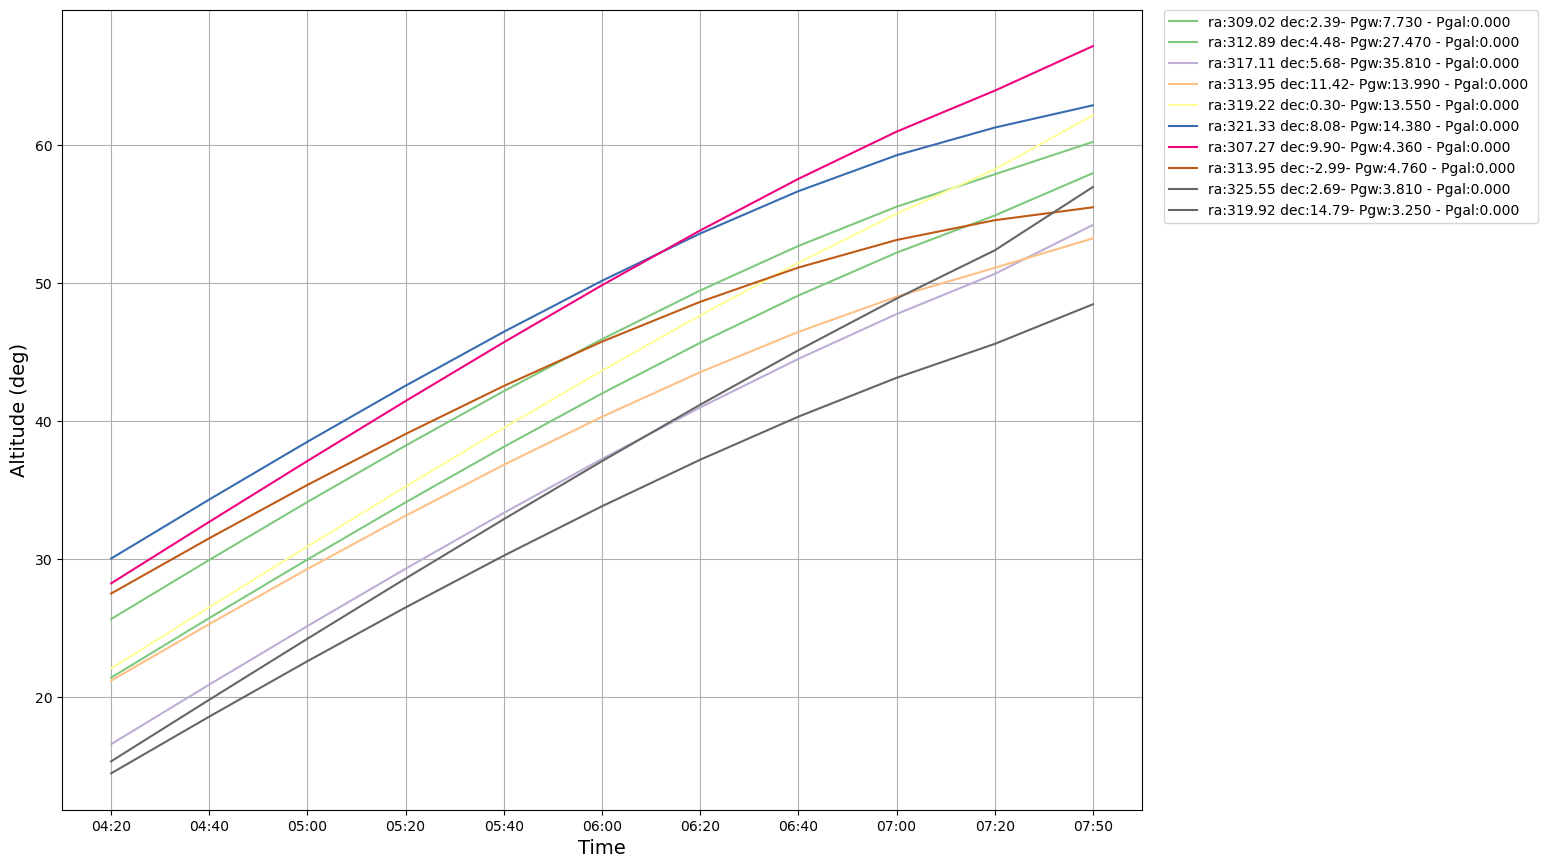

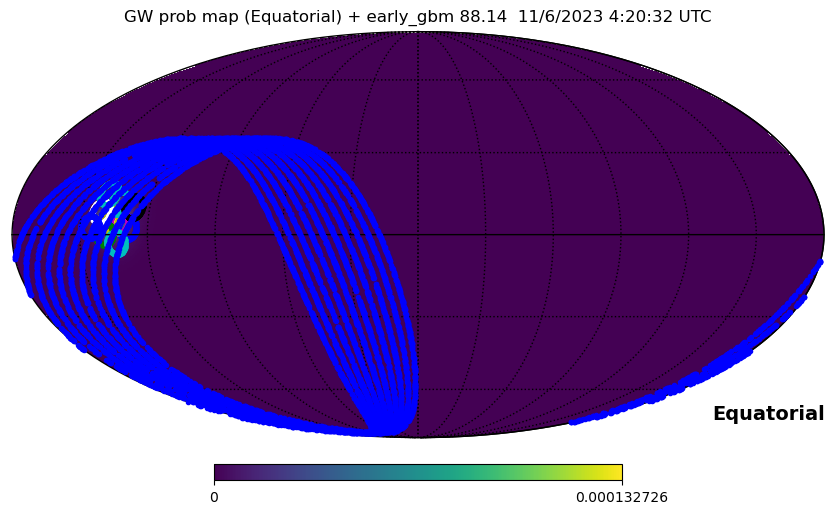

In [7]:
GetSchedule(obspar_locprob)

## 🔵 Testing Tiling with a Simulated Gaussian Localization Map

In this test, we demonstrate the use of a **simulated Gaussian localization** as an input sky map for tiling. This mode is especially useful when:

- You want to test the full tiling and scheduling pipeline without a real GRB map.
- You are performing simulations with synthetic events.
- You want to model a localization uncertainty similar to an alert system (e.g., Fermi-GBM) but without relying on real FITS files.

### ✅ Features of the Gaussian Mode

The Gaussian mode simulates a HEALPix sky map where the probability distribution follows a 2D angular Gaussian centered at a given RA/Dec, with a specified width.

- **Center (RA, Dec)**: Represents the location of the simulated transient (in degrees).
- **Sigma**: Angular width of the Gaussian, in degrees (i.e., how spread out the localization is).
- **Nside**: The HEALPix resolution of the map.

This setup is useful for validation, performance testing, and optimizing tiling strategies without needing a real alert.

### 📌 Example Parameters

- RA = 312.89°
- Dec = 4.5°
- Sigma = 3.0°
- NSIDE = 512 (fine resolution)

These parameters are injected into the `ObservationParameters` object, and the map is created using the `GaussianMapReader` via the factory function `create_map_reader()`.

Below we show how to configure this simulated Gaussian map and use it in the standard `SkyMap` interface.


In [19]:


obspar_gauss = ObservationParameters()
obspar_gauss.add_parsed_args(None,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_gauss.from_configfile(cfgFile)
obspar_gauss.mode = "gaussian"
obspar_gauss.raSource = 312.89
obspar_gauss.decSource = 4.5
obspar_gauss.sigmaSource = 3.
obspar_gauss.nside = 512

reader_gauss = create_map_reader(obspar_gauss)
skymap_gauss = SkyMap(obspar_gauss, reader_gauss)


Starting the 2D pointing calculation with the following parameters

Filename:  None
Date:  2023-06-10 14:51:47
Previous pointings:  None
Dataset:  ../../tilepy/dataset/
Output:  ./output/None

============== Main parsed observation parameters ==============  
Observatory Name: CTAO-S
Event Name: None
Observatory: -24.5 deg
Observatory: -70.17 deg
Observatory: 2635.0 m
Max zenith: 60
Using Greytime is: True
FOV: 4.0
Max runs: 20
Duration: 20
High Resolution NSIDE: 512
Low Resolution NSIDE: 128
The strategy is (3D, integrated, mangrove=False)
The level of details is (doPlot=True, doRank = True)


-------------------   NEW EVENT   --------------------

----------   NEW FOLLOW-UP ATTEMPT   ----------

Total GW probability covered:  0.9803 Number of runs that fulfill darkness condition  : 32 Number of effective pointings:  7

================================= Tiling found =============================================
     Time[UTC]      RA[deg]  DEC[deg]  PGW   Round ObsName Duration FoV
--

/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


./output/None/PGinFoV
Loading pointings from ./output/None/PGinFoV/SuggestedPointings_2DProbOptimisation.txt
----------   PLOTTING THE SCHEDULING   ----------
Total covered probability with the scheduled tiles is PGW= 0.98030
No galaxies given


/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)


No galaxies given for plot 2


/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format (vectorized)
  outputs = ufunc(*inputs)
/Users/edna/software/miniconda3/envs/tilepyenv-new/lib/python3.11/site-packages/numpy/lib/function_base.py:2455: RuntimeWarning: invalid value encountered in do_format 

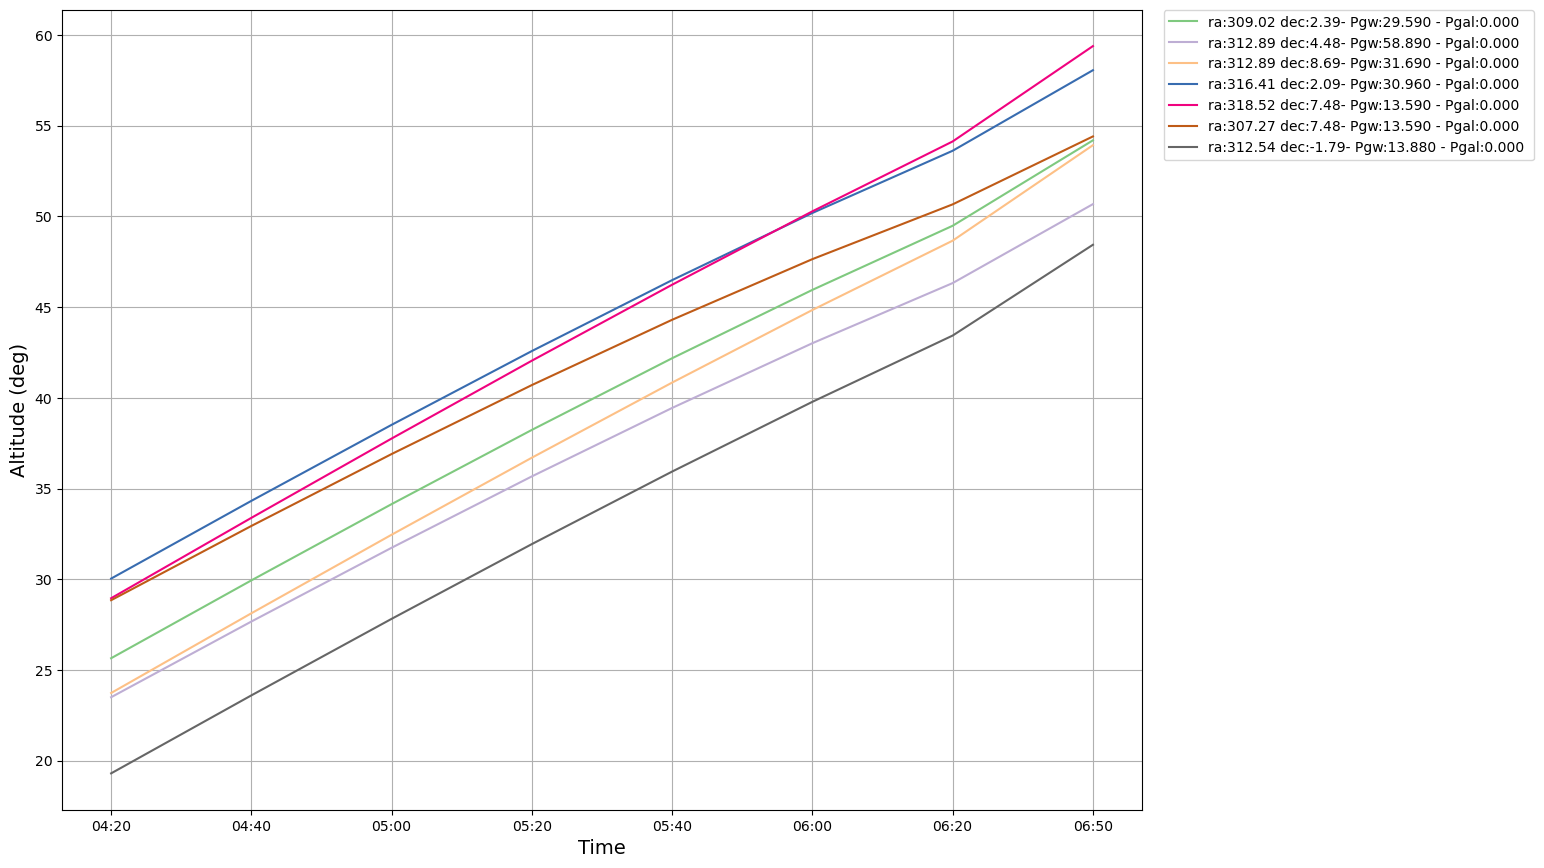

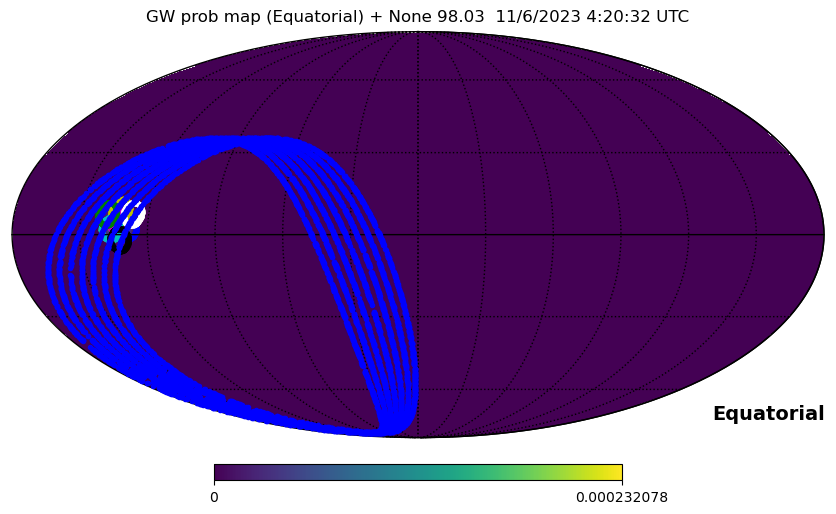

In [20]:
GetSchedule(obspar_gauss)


In [21]:
skymap_gauss.getArea(0.9)


<Quantity 129.94626141 deg2>

In [22]:
isinstance(reader_gauss, MapReader)

True

In [23]:
obspar_gauss.mode

'gaussian'

## 🔶 Testing Tiling with a Standard Fermi-GBM HEALPix Map (`glg_healpix_all`)

In this section, we test the standard `tilepy` pipeline using the **official Fermi-GBM HEALPix localization map**, typically released **hours after the trigger** and containing the full posterior sky probability distribution.

### 📄 File Format: `glg_healpix_all_*.fit`

These maps:
- Follow the [HEALPix](https://healpix.sourceforge.io) format (`NESTED` scheme).
- Contain high-resolution, all-sky localization probability (in units of probability **density**, sr⁻¹).
- May also include 3D distance information (mean, std, norm) for advanced scheduling.

### ✅ Key Use Cases

- Accurate follow-up planning with full localization fidelity.
- Comparison against early `locprob` or Gaussian approximations.
- Used for statistical population studies or realistic GRB follow-up simulations.

### ⚙️ Setup

We initialize the `ObservationParameters` object with:
- A full path to a `glg_healpix_all_*.fit` map.
- Observation time, config file, dataset, and output directory.

The factory function `create_map_reader()` will identify this as a standard HEALPix map and return a `HealpixMapReader` instance. The map is automatically interpreted as a **probability density** (sr⁻¹), and converted to a `HealpixMap` for further analysis.

This is the most commonly used GBM map type for follow-up.


In [24]:
#Parse the parameters 
obspar_healpix = ObservationParameters()
skymap = './glg_healpix_all_bn240612503_v00.fit'
obsTime = datetime.datetime.fromisoformat("2023-06-10 14:51:47")
datasetDir = '../../tilepy/dataset/'
outDir = './output'
cfgFile = '../config/FollowupParameters_CTAOS.ini'
pointingsFile = None


obspar_healpix.add_parsed_args(skymap,obsTime,datasetDir,None,outDir,pointingsFile)
obspar_healpix.from_configfile(cfgFile)

In [25]:
obspar_healpix.mode

In [26]:
reader_healpix = create_map_reader(obspar_healpix)


In [27]:
skymap_healpix = SkyMap(obspar_healpix, reader_healpix)
skymap_healpix.getArea(0.9)


<Quantity 187.5821297 deg2>

# Plot each map type generated

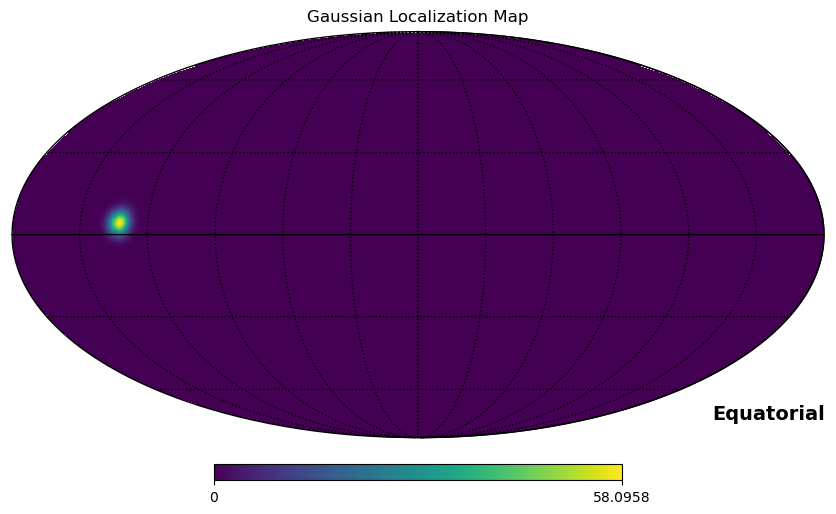

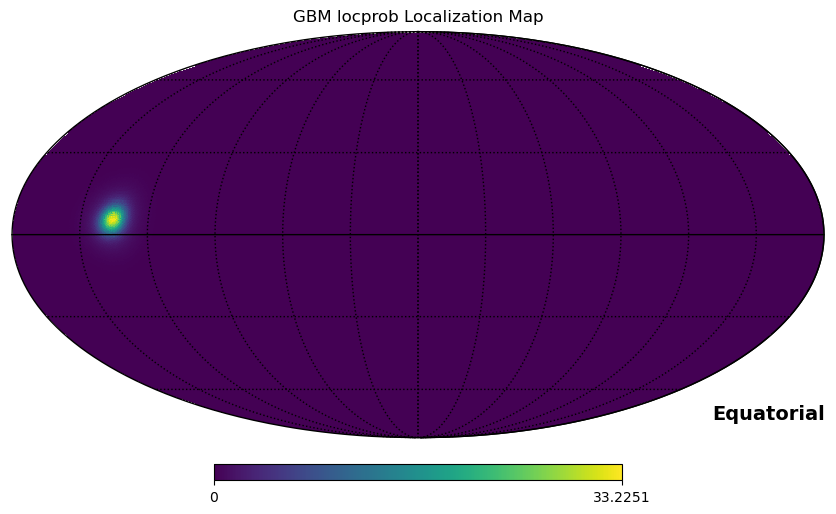

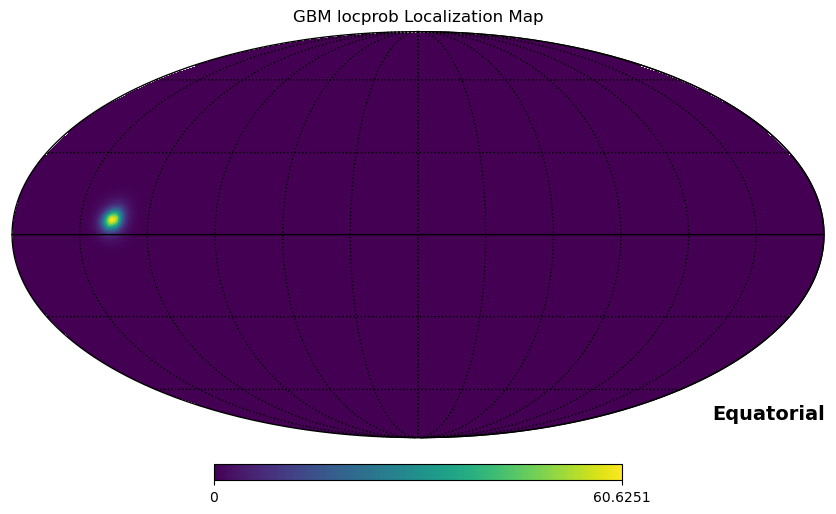

In [28]:
import matplotlib.pyplot as plt

# Plot Gaussian Localization Map
hp.mollview(reader_gauss.getMap("prob").data, title="Gaussian Localization Map", rot=[180, 0],
            coord="C", nest = True)
hp.graticule()

# Plot GBM Localization Map
hp.mollview(reader.getMap("prob").data, title="GBM locprob Localization Map",rot=[180, 0],
            coord="C",nest = True)
hp.graticule()

# Plot GBM Localization Map
hp.mollview(reader_healpix.getMap("prob").data, title="GBM locprob Localization Map",rot=[180, 0],
            coord="C",nest = True)
hp.graticule()

plt.show()